# Ranking System in Tensorflow

## Set Up Environment

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install and import packages
!pip install tensorflow-recommenders
!pip install --upgrade tensorflow-datasets
import os
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from typing import Dict, Text
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import datetime
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
warnings.filterwarnings('ignore')
my_dpi = 96
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi
print('\n')
print('TensorFlow version: {}'.format(tf.__version__))
print('Eager execution is: {}'.format(tf.executing_eagerly()))
print('Keras version: {}'.format(tf.keras.__version__))
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))
print('\n')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.6.0
    Uninstalling tensorflow-datasets-4.6.0:
      Successfully uninstalled tensorflow-datasets-4.6.0
CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Tue Jan 10 05:10:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-----

In [ ]:
# Reproducibility in TF 
def init_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    os.environ['AmazonReviews_RecSysDL'] = str(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = 'True'
    os.environ['TF_DETERMINISTIC_OPS'] = 'True'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=42)

## Examine and Process Data

In [ ]:
%cd /content/drive/MyDrive/AmazonReviews/Data/

/content/drive/MyDrive/AmazonReviews/Data


In [ ]:
# Read data
df = pd.read_csv('Movies_and_TV.csv', header=None, skiprows=[0],
                 low_memory=False)
df = df.drop_duplicates()

# Name columns
df.columns = ['item', 'reviewerID', 'rating', 'timestamp']

print('Sample observations:')
df.head()

Sample observations:


,item,reviewerID,rating,timestamp
0,0001527665,A2VHSG6TZHU1OB,5.0,1361145600
1,0001527665,A23EJWOW1TLENE,5.0,1358380800
2,0001527665,A1KM9FNEJ8Q171,5.0,1357776000
3,0001527665,A38LY2SSHVHRYB,4.0,1356480000
4,0001527665,AHTYUW2H1276L,5.0,1353024000


In [ ]:
# Data summary
def data_summary(df):
    print('Number of Rows: {}, Columns: {}'.format(df.shape[0], df.shape[1]))
    a = pd.DataFrame()
    a['Number of Unique Values'] = df.nunique()
    a['Number of Missing Values'] = df.isnull().sum()
    a['Data type of variable'] = df.dtypes
    print(a)

print('\nData Summary')     
print(data_summary(df))

df = df.drop(['timestamp'], axis=1)


Data Summary
Number of Rows: 8522125, Columns: 4
            Number of Unique Values  Number of Missing Values  \
item                         182032                         0   
reviewerID                  3826085                         0   
rating                            5                         0   
timestamp                      7476                         0   

           Data type of variable  
item                      object  
reviewerID                object  
rating                   float64  
timestamp                  int64  
None


<font size="4">The top 10 reviewers with the most number of ratings in the initial set shows that they have over 1,600 reviews.<font>

In [ ]:
reviewers_top10 = df.groupby('reviewerID').size().sort_values(ascending=False)[:10]
print('Reviewers with highest number of ratings in initial set:')
print(reviewers_top10)

Reviewers with highest number of ratings in initial set:
reviewerID
AV6QDP8Q0ONK4     4101
A1GGOC9PVDXW7Z    2114
ABO2ZI2Y5DQ9T     2073
A328S9RN3U5M68    2059
A3MV1KKHX51FYT    1989
A2EDZH51XHFA9B    1842
A3LZGLA88K0LA0    1814
A16CZRQL23NOIW    1808
AIMR915K4YCN      1719
A2NJO6YE954DBH    1699
dtype: int64


<font size="4">The top 10 items in the initial set shows the highest item has 24,554 ratings while the 10th highest items has 14,171 ratings. <font>

In [ ]:
items_top10 = df.groupby('item').size().sort_values(ascending=False)[:10]
print('Items with highest number of ratings in initial set:')
print(items_top10)

Items with highest number of ratings in initial set:
item
B00YSG2ZPA    24554
B00006CXSS    24485
B00AQVMZKQ    21015
B01BHTSIOC    20889
B00NAQ3EOK    16857
6305837325    16671
B00WNBABVC    15205
B017S3OP7A    14795
B009934S5M    14481
B00FL31UF0    14174
dtype: int64


<font size="4">The data is then filtered to reviewers who have greater than or equal to 25 reviews due to sparsity. This results in a set containing 1,114,877 ratings with 19,702 unique reviewers and 103,731 unique items. The majority of items are rated 5 star.<font>

In [ ]:
reviewer_count = df.reviewerID.value_counts()
df = df[df.reviewerID.isin(reviewer_count[reviewer_count >= 25].index)]
df[['reviewerID', 'item']] = df[['reviewerID', 'item']].astype('str')
df['rating'] = df['rating'].astype('float32')
df = df.drop_duplicates()

del reviewer_count

print('- Number of ratings after filtering: ', len(df))
print('- Number of unique reviewers: ', df['reviewerID'].nunique())
print('- Number of unique items: ', df['item'].nunique())
print('\n')

for i in range(1,6):
  print('- Number of items with {0} rating = {1}'.format(i, df[df['rating'] == i].shape[0]))

- Number of ratings after filtering:  1114877
- Number of unique reviewers:  19702
- Number of unique items:  103731


- Number of items with 1 rating = 59576
- Number of items with 2 rating = 65630
- Number of items with 3 rating = 141579
- Number of items with 4 rating = 252845
- Number of items with 5 rating = 595247


In [ ]:
reviewers_top10 = df.groupby('reviewerID').size().sort_values(ascending=False)[:10]
print('Reviewers with highest number of ratings in initial set:')
print(reviewers_top10)

Reviewers with highest number of ratings in initial set:
reviewerID
AV6QDP8Q0ONK4     3981
ABO2ZI2Y5DQ9T     2068
A328S9RN3U5M68    1997
A3MV1KKHX51FYT    1986
A2EDZH51XHFA9B    1838
A3LZGLA88K0LA0    1811
A16CZRQL23NOIW    1797
A1GGOC9PVDXW7Z    1733
AIMR915K4YCN      1706
A20EEWWSFMZ1PN    1634
dtype: int64


<font size="4">The top 10 items in the initial set shows the highest item has 1,136 ratings while the 10th highest items has 853 ratings. <font>

In [ ]:
items_top10 = df.groupby('item').size().sort_values(ascending=False)[:10]
print('Items with highest number of ratings in initial set:')
print(items_top10)

Items with highest number of ratings in initial set:
item
B009934S5M    1136
B00PY4Q9OS    1042
B00R8GUXPG    1040
B00Q0G2VXM    1040
B00NYC65M8     965
B00OV3VGP0     903
B00DY64A3U     895
B00D91GRA4     870
B0059XTU3G     860
B005LAIHY0     853
dtype: int64


## Load Data into a Tensorflow Dataset and Prepare for Modeling

In [ ]:
# Load pandas df to tf
ratings = tf.data.Dataset.from_tensor_slices(dict(df))

In [ ]:
# Map the vars in tf Dataseet
ratings = ratings.map(lambda x: {'item': x['item'],
                                 'reviewer_id': x['reviewerID'],
                                 'rating': x['rating']})

In [ ]:
# Prepare train/test sets
shuffled = ratings.shuffle(1_000_000, seed=42, reshuffle_each_iteration=False)
train = shuffled.take(500_000)
test = shuffled.skip(500_000).take(100_000)

In [ ]:
# Generate vocab that maps feature to embedding vector in model
items = ratings.batch(3_000_000).map(lambda x: x['item'])
reviewer_ids = ratings.batch(3_000_000).map(lambda x: x['reviewer_id'])

# Find unique items and reviewer_ids for vocab
unique_items = np.unique(np.concatenate(list(items)))
unique_reviewer_ids = np.unique(np.concatenate(list(reviewer_ids)))

# Set embedding dimension
embedding_dimension = 64

## Define Model Architecture and Metrics

The ranking model computes embeddings for the reviewers annd items which are used as input to multiple stacked `Dense` layers containing `activation='relu'`. 

In [ ]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    
    """
    Initialize the model by setting up the layers.
    """
    super().__init__()
    
    # Compute embeddings for reviewers
    self.reviewer_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_reviewer_ids, 
                                   mask_token=None),
      tf.keras.layers.Embedding(len(unique_reviewer_ids) + 1, 
                                embedding_dimension)])

    # Compute embeddings for items
    self.item_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(vocabulary=unique_items, mask_token=None),
      tf.keras.layers.Embedding(len(unique_items) + 1, embedding_dimension)])

    # Add multiple dense layers and predict ratings
    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)])
    
  def call(self, inputs):

    reviewer_id, item = inputs
    reviewer_embedding = self.reviewer_embeddings(reviewer_id)
    item_embedding = self.item_embeddings(item)

    return self.ratings(tf.concat([reviewer_embedding, item_embedding], axis=1))

In [ ]:
# Find the predicted rating given reviewer_id and item
RankingModel()((['31'], ['2726956']))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00874423]], dtype=float32)>

In [ ]:
# Loss and metrics
task = tfrs.tasks.Ranking(loss=tf.keras.losses.MeanSquaredError(),
                          metrics=[tf.keras.metrics.RootMeanSquaredError()])

## Define Complete Model
The `RankingModel()` is added in the `__init__` method, and the `compute_loss` method calculates a loss given the feautres as input. The base model creates the training loop. 

In [ ]:
class AmazonReviewsModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['reviewer_id'], features['item']))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop('rating')
    rating_predictions = self(features)

    # Computes the loss and the metrics
    return self.task(labels=labels, predictions=rating_predictions)

In [ ]:
# Initiate the model
model = AmazonReviewsModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

In [ ]:
# Shuffle, batch, and cache the train/test sets
cached_train = train.shuffle(1_000_000).batch(1).cache()  
cached_test = test.batch(1).cache()

## Fit, Evaluate and Save Model

In [ ]:
# Set path for results
%cd /content/drive/MyDrive/AmazonReviews/DL/Models/

/content/drive/MyDrive/AmazonReviews/DL/Models


In [ ]:
# Set up logs
!rm -rf /logs/

%load_ext tensorboard

log_folder = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Set up callbacks
filepath = 'rankingBaseline_MoviesTV_weights_only.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='root_mean_squared_error', patience=3),
                  ModelCheckpoint(filepath, monitor='root_mean_squared_error', 
                                  save_weights_only=True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Fit model
history = model.fit(cached_train, epochs=20, callbacks=callbacks_list)

Epoch 1/20
500000/500000 [==============================] - 1359s 3ms/step - root_mean_squared_error: 0.8855 - loss: 0.7844 - regularization_loss: 0.0000e+00 - total_loss: 0.7844
Epoch 2/20
500000/500000 [==============================] - 1350s 3ms/step - root_mean_squared_error: 0.8323 - loss: 0.6929 - regularization_loss: 0.0000e+00 - total_loss: 0.6929
Epoch 3/20
500000/500000 [==============================] - 1351s 3ms/step - root_mean_squared_error: 0.7777 - loss: 0.6051 - regularization_loss: 0.0000e+00 - total_loss: 0.6051
Epoch 4/20
500000/500000 [==============================] - 1346s 3ms/step - root_mean_squared_error: 0.7191 - loss: 0.5173 - regularization_loss: 0.0000e+00 - total_loss: 0.5173
Epoch 5/20
500000/500000 [==============================] - 1344s 3ms/step - root_mean_squared_error: 0.6644 - loss: 0.4416 - regularization_loss: 0.0000e+00 - total_loss: 0.4416
Epoch 6/20
500000/500000 [==============================] - 1345s 3ms/step - root_mean_squared_error: 0.6

In [ ]:
# Save model
tf.saved_model.save(model, 'rankingBaseline_MoviesTV_20epochs')

In [ ]:
# Evaluate on test set
model.evaluate(cached_test, return_dict=True)

100000/100000 [==============================] - 197s 2ms/step - root_mean_squared_error: 1.2426 - loss: 1.5440 - regularization_loss: 0.0000e+00 - total_loss: 1.5440


{'root_mean_squared_error': 1.2425607442855835,
 'loss': 0.1961183398962021,
 'regularization_loss': 0,
 'total_loss': 0.1961183398962021}

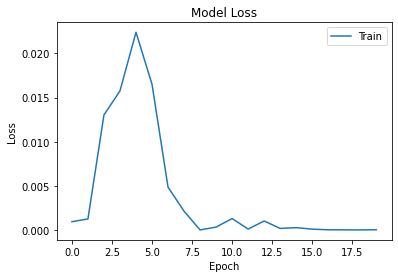

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Eval'], loc='upper right')
plt.savefig('TF_rankingBaseline_MoviesTV_20Epochs_Loss.png', dpi=my_dpi*10,
            bbox_inches='tight')
plt.show()

In [ ]:
# Plot loss over epochs
loss = pd.DataFrame(history.history['loss'], columns=['loss'])
loss.to_csv('/baselineRanking_20epochs_loss.csv', index=False)

In [ ]:
# Load model
loaded = tf.saved_model.load('rankingBaseline_MoviesTV_20epochs')
loaded({'reviewer_id': np.array(['AV6QDP8Q0ONK4']), 
        'item': ['B009934S5M']}).numpy()

array([[4.7614393]], dtype=float32)

In [ ]:
# Evaluate
model.evaluate(cached_test, return_dict=True)

100000/100000 [==============================] - 204s 2ms/step - root_mean_squared_error: 1.2426 - loss: 1.5440 - regularization_loss: 0.0000e+00 - total_loss: 1.5440


{'root_mean_squared_error': 1.2425607442855835,
 'loss': 0.1961183398962021,
 'regularization_loss': 0,
 'total_loss': 0.1961183398962021}

## Test the Ranking Model

Compute predictions for a subset of items and rank based on the predictions:


#### AV6QDP8Q0ONK4

In [ ]:
test_ratings = {}
test_item = ['B009934S5M','B00PY4Q9OS', 'B00R8GUXPG','B00Q0G2VXM','B00NYC65M8']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['AV6QDP8Q0ONK4']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00NYC65M8: [[5.2519903]]
B00R8GUXPG: [[4.836647]]
B009934S5M: [[4.7614393]]
B00PY4Q9OS: [[4.7345595]]
B00Q0G2VXM: [[4.623266]]


#### ABO2ZI2Y5DQ9T

In [ ]:
test_ratings = {}
test_item = ['B009934S5M','B00PY4Q9OS', 'B00R8GUXPG','B00Q0G2VXM','B00NYC65M8']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['ABO2ZI2Y5DQ9T']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00R8GUXPG: [[4.1731825]]
B00PY4Q9OS: [[3.9811945]]
B009934S5M: [[3.6320379]]
B00NYC65M8: [[3.6279793]]
B00Q0G2VXM: [[3.5430803]]


In [ ]:
test_ratings = {}
test_item = ['B00KHW4XHM', 'B01F6EHOIK', 'B00199PP6U', 'B00009IAXL']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['ABO2ZI2Y5DQ9T']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00KHW4XHM: [[4.799788]]
B00199PP6U: [[4.7554584]]
B00009IAXL: [[3.4191265]]
B01F6EHOIK: [[1.9375358]]


In [ ]:
test_ratings = {}
test_item = ['B0006FFRKM', '6304492952', 'B009934S5M', 'B000HT3QBY']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['ABO2ZI2Y5DQ9T']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B0006FFRKM: [[5.2371516]]
B009934S5M: [[3.6320379]]
B000HT3QBY: [[3.4291909]]
6304492952: [[3.126309]]


#### A328S9RN3U5M68

In [ ]:
test_ratings = {}
test_item = ['B009934S5M','B00PY4Q9OS', 'B00R8GUXPG','B00Q0G2VXM','B00NYC65M8']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A328S9RN3U5M68']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00R8GUXPG: [[4.9083266]]
B00PY4Q9OS: [[4.6880455]]
B009934S5M: [[4.497545]]
B00Q0G2VXM: [[4.416779]]
B00NYC65M8: [[3.2599416]]


In [ ]:
test_ratings = {}
test_item = ['B00KHW4XHM', 'B01F6EHOIK', 'B00199PP6U', 'B00009IAXL']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A328S9RN3U5M68']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00KHW4XHM: [[5.38043]]
B00199PP6U: [[5.1638284]]
B00009IAXL: [[3.2683938]]
B01F6EHOIK: [[3.0241704]]


In [ ]:
test_ratings = {}
test_item = ['B0006FFRKM', '6304492952', 'B009934S5M', 'B000HT3QBY']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A328S9RN3U5M68']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B0006FFRKM: [[5.147983]]
B009934S5M: [[4.497545]]
B000HT3QBY: [[4.3494844]]
6304492952: [[3.8749783]]


#### A3MV1KKHX51FYT

In [ ]:
test_ratings = {}
test_item = ['B009934S5M','B00PY4Q9OS', 'B00R8GUXPG','B00Q0G2VXM','B00NYC65M8']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A3MV1KKHX51FYT']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B009934S5M: [[3.0159693]]
B00Q0G2VXM: [[2.8539734]]
B00R8GUXPG: [[2.4100082]]
B00PY4Q9OS: [[2.2210793]]
B00NYC65M8: [[2.1591673]]


In [ ]:
test_ratings = {}
test_item = ['B00KHW4XHM', 'B01F6EHOIK', 'B00199PP6U', 'B00009IAXL']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A3MV1KKHX51FYT']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B00009IAXL: [[4.1028647]]
B00KHW4XHM: [[3.1912699]]
B00199PP6U: [[2.5072653]]
B01F6EHOIK: [[1.9650021]]


In [ ]:
test_ratings = {}
test_item = ['B0006FFRKM', '6304492952', 'B009934S5M', 'B000HT3QBY']
for item in test_item:
  test_ratings[item] = model({
      'reviewer_id': np.array(['A3MV1KKHX51FYT']),
      'item': np.array([item])})

print('Ratings:')
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], 
                           reverse=True):
  print(f'{title}: {score}')

Ratings:
B000HT3QBY: [[5.27298]]
B0006FFRKM: [[3.945326]]
B009934S5M: [[3.0159693]]
6304492952: [[2.4662666]]


## Convert the model to TF Lite to run on-device

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('rankingBaseline_MoviesTV_20epochs')
tflite_model = converter.convert()
open('converted_model.tflite', 'wb').write(tflite_model)

34591500

In [ ]:
interpreter = tf.lite.Interpreter(model_path='converted_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model.
if input_details[0]['name'] == 'serving_default_item:0':
  interpreter.set_tensor(input_details[0]['index'], np.array(['B009934S5M']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['AV6QDP8Q0ONK4']))
else:
  interpreter.set_tensor(input_details[0]['index'], np.array(['AV6QDP8Q0ONK4']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['B009934S5M']))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

[[4.7614403]]


In [ ]:
# Test the model.
if input_details[0]['name'] == 'serving_default_item:0':
  interpreter.set_tensor(input_details[0]['index'], np.array(['B00PY4Q9OS']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['ABO2ZI2Y5DQ9T']))
else:
  interpreter.set_tensor(input_details[0]['index'], np.array(['ABO2ZI2Y5DQ9T']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['B00PY4Q9OS']))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

[[3.9811943]]


In [ ]:
# Test the model.
if input_details[0]['name'] == 'serving_default_item:0':
  interpreter.set_tensor(input_details[0]['index'], np.array(['B00R8GUXPG']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['A328S9RN3U5M68']))
else:
  interpreter.set_tensor(input_details[0]['index'], np.array(['A328S9RN3U5M68']))
  interpreter.set_tensor(input_details[1]['index'], np.array(['B00R8GUXPG']))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

[[4.9083266]]
